In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report


import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

Cloning into 'TextGraphs17-shared-task'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 506 (delta 9), reused 20 (delta 4), pack-reused 480
Receiving objects: 100% (506/506), 37.13 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [5]:
!ls TextGraphs17-shared-task

README.md  data        question_graph_examples	submission_example
baselines  evaluation  reformat_data		visualization


In [6]:
train_dev_path = "TextGraphs17-shared-task/data/tsv/train.tsv"

data_df = pd.read_csv(train_dev_path, sep='\t')

pd.set_option('display.max_colwidth', None)

In [7]:
all_questions = list(data_df["question"].unique())
num_questions = len(all_questions)
random.shuffle(all_questions)

In [8]:
train_dev_ratio = 0.8
train_ratio = 0.9
num_train_dev_questions = int(num_questions * train_dev_ratio)
train_dev_questions = all_questions[:num_train_dev_questions]
test_questions = set(all_questions[num_train_dev_questions:])
num_train_questions = int(len(train_dev_questions) * train_ratio)
train_questions = set(train_dev_questions[:num_train_questions])
dev_questions = set(train_dev_questions[num_train_questions:])

print(f"Questions: train - {len(train_questions)}, dev - {len(dev_questions)}, test - {len(dev_questions)}")

Questions: train - 2545, dev - 283, test - 283


In [9]:
train_df = data_df[data_df["question"].isin(train_questions)]
dev_df = data_df[data_df["question"].isin(dev_questions)]
test_df = data_df[data_df["question"].isin(test_questions)]

print(f"Train: {train_df.shape}")
print(f"Dev: {dev_df.shape}")
print(f"Test: {test_df.shape}")

Train: (27122, 10)
Dev: (3047, 10)
Test: (7503, 10)


In [10]:
train_df["label"] = train_df["correct"].astype(np.float32)
dev_df["label"] = dev_df["correct"].astype(np.float32)
test_df["label"] = test_df["correct"].astype(np.float32)
train_df["label"].head(5)

/tmp/ipykernel_24/3117296500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["correct"].astype(np.float32)
/tmp/ipykernel_24/3117296500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["label"] = dev_df["correct"].astype(np.float32)
/tmp/ipykernel_24/3117296500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: label, dtype: float32

In [11]:
train_df["graph"] = train_df["graph"].apply(eval)
dev_df["graph"] = dev_df["graph"].apply(eval)
test_df["graph"] = test_df["graph"].apply(eval)

/tmp/ipykernel_24/1764180835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["graph"] = train_df["graph"].apply(eval)
/tmp/ipykernel_24/1764180835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["graph"] = dev_df["graph"].apply(eval)
/tmp/ipykernel_24/1764180835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [12]:
data_df.head(1)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': ""Ruhollah Khomeini's return to Iran""}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}"


In [13]:
class QuestionAnswerDataset(Dataset):

    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first", graph_length="length", graph_density="density"):
        super(QuestionAnswerDataset).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        self.graph_length = df[graph_length].values
        self.graph_density = df[graph_density].values
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        assert len(self.questions) == len(self.contexts) == len(self.labels)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
                "input_ids": self.tokenized_input[idx]["input_ids"][0],
                "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
                "labels": self.labels[idx],
                "graph_length": self.graph_length[idx],
                "graph_density": self.graph_density[idx],
                }

# Graph Linearization

In [14]:
model_name="sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
SEP_TOKEN = tokenizer.sep_token

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
# {'directed': True, 'multigraph': False, 'graph': {},
# 'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q49', 'id': 0, 'label': 'North America'},
# {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q194057', 'id': 1, 'label': 'Mount Rainier'}],
# 'links': [{'name_': 'P30', 'source': 1, 'target': 0, 'label': 'continent'}]}
def linearize_graph(graph_dict):
    graph_dict = graph_dict["graph"]

    nodes = sorted((node_dict for node_dict in graph_dict["nodes"]), key=lambda d:d["id"])

    len_nodes = len(nodes)
    len_links = len(graph_dict["links"])
    if len_nodes > 1:
        kn_density =  len_links / (len_nodes * (len_nodes - 1))
    else:
        kn_density =  len_links / (len_nodes * (len_nodes))


    for n_id, node_dict in enumerate(nodes):
        assert n_id == node_dict["id"]
    src_node_id2links = {}

    for link_dict in graph_dict["links"]:

        link_src =  link_dict["source"]

        if src_node_id2links.get(link_src) is None:
            src_node_id2links[link_src] = []
        src_node_id2links[link_src].append(link_dict)

    graph_s = ""

    for n_id, node_dict in enumerate(nodes):
        links = src_node_id2links.get(n_id, list())
        start_label = node_dict["label"]
        if node_dict["type"] == "ANSWER_CANDIDATE_ENTITY":
            start_label = f"{SEP_TOKEN} {start_label} {SEP_TOKEN}"
        for link_dict in links:
            target_label = nodes[link_dict["target"]]["label"]
            if nodes[link_dict["target"]]["type"] == "ANSWER_CANDIDATE_ENTITY":
                target_label = f"{SEP_TOKEN} {target_label} {SEP_TOKEN}"
            link_s = f" {start_label}, {link_dict['label']}, {target_label} "

            graph_s += link_s
        # graph_s += node_dict["label"]
        # if n_id != len(nodes) - 1:
        #     link_label = link["label"]
        #     graph_s += link_label
    #print('--------')
    return graph_s, len_nodes, kn_density

In [16]:
train_df.head(1)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0


In [17]:
train_df["graph"][0]

{'nodes': [{'type': 'QUESTIONS_ENTITY',
   'name_': 'Q794',
   'id': 0,
   'label': 'Iran'},
  {'type': 'INTERNAL',
   'name_': 'Q207991',
   'id': 1,
   'label': 'Pahlavi dynasty'},
  {'type': 'ANSWER_CANDIDATE_ENTITY',
   'name_': 'Q7293530',
   'id': 2,
   'label': "Ruhollah Khomeini's return to Iran"}],
 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'},
  {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'},
  {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'},
  {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}

In [18]:
train_df["linearized_graph"], train_df["length"], train_df["density"] = zip(*train_df.apply(linearize_graph, axis=1))
dev_df["linearized_graph"], dev_df["length"], dev_df["density"] = zip(*dev_df.apply(linearize_graph, axis=1))
test_df["linearized_graph"], test_df["length"], test_df["density"] = zip(*test_df.apply(linearize_graph, axis=1))

/tmp/ipykernel_24/648362694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["linearized_graph"], train_df["length"], train_df["density"] = zip(*train_df.apply(linearize_graph, axis=1))
/tmp/ipykernel_24/648362694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["linearized_graph"], train_df["length"], train_df["density"] = zip(*train_df.apply(linearize_graph, axis=1))
/tmp/ipykernel_24/648362694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [19]:
train_df.head(2)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label,linearized_graph,length,density
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0,"Iran, country, Iran Iran, replaces, Pahlavi dynasty Pahlavi dynasty, replaced by, Iran [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty",3,0.666667
1,1,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q4173137', 'id': 0, 'label': 'Jewish Encyclopedia of Brockhaus and Efron'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 1, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q47461344', 'id': 2, 'label': 'written work'}, {'type': 'INTERNAL', 'name_': 'Q133492', 'id': 3, 'label': 'letter'}, {'type': 'INTERNAL', 'name_': 'Q1030940', 'id': 4, 'label': 'The Book of Healing'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q5952984', 'id': 5, 'label': 'Ruhollah Khomeini's letter to Mikhail Gorbachev'}], 'links': [{'name_': 'P1343', 'source': 1, 'target': 0, 'label': 'described by source'}, {'name_': 'P17', 'source': 1, 'target': 1, 'label': 'country'}, {'name_': 'P1343', 'source': 3, 'target': 0, 'label': 'described by source'}, {'name_': 'P279', 'source': 3, 'target': 2, 'label': 'subclass of'}, {'name_': 'P495', 'source': 4, 'target': 1, 'label': 'country of origin'}, {'name_': 'P31', 'source': 4, 'target': 2, 'label': 'instance of'}, {'name_': 'P31', 'source': 5, 'target': 2, 'label': 'instance of'}, {'name_': 'P31', 'source': 5, 'target': 3, 'label': 'instance of'}]}",0.0,"Iran, described by source, Jewish Encyclopedia of Brockhaus and Efron Iran, country, Iran letter, described by source, Jewish Encyclopedia of Brockhaus and Efron letter, subclass of, written work The Book of Healing, country of origin, Iran The Book of Healing, instance of, written work [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, written work [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, letter",6,0.266667


# Data exploration

In [20]:
train_exploration_df = pd.DataFrame()
train_exploration_df["correct"], train_exploration_df["length"], train_exploration_df["density"] = train_df["correct"], train_df["length"], train_df["density"]
train_exploration_df.head(3)

,correct,length,density
0,False,3,0.666667
1,False,6,0.266667
2,False,2,1.500000


array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'density'}>]], dtype=object)

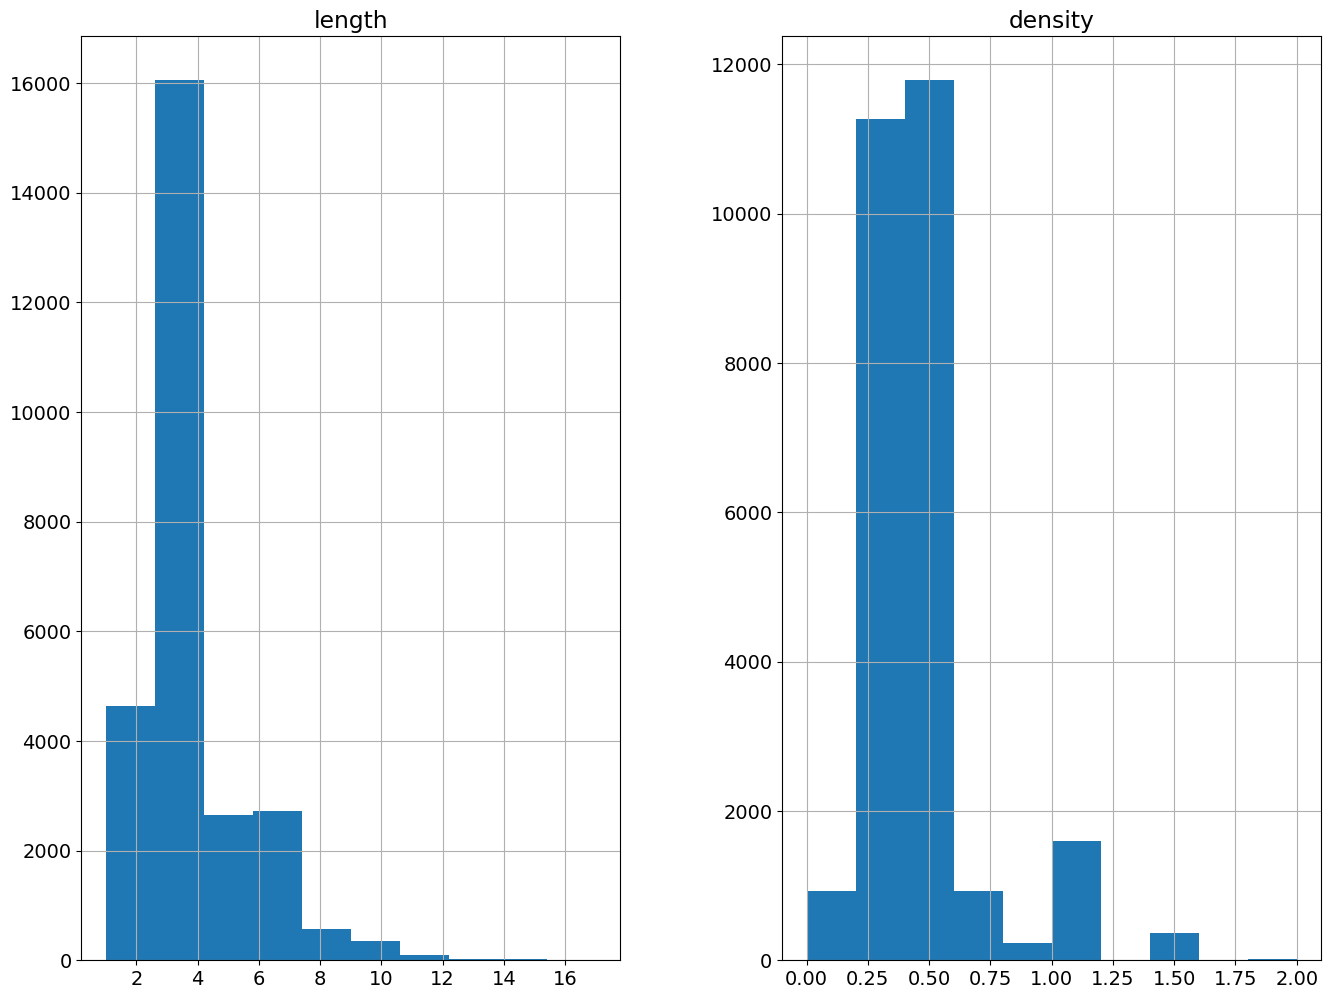

In [21]:
train_exploration_df.hist()

In [22]:
train_exploration_df.groupby("correct").mean()

,length,density
correct,,
False,3.925680,0.440844
True,3.086342,0.545361


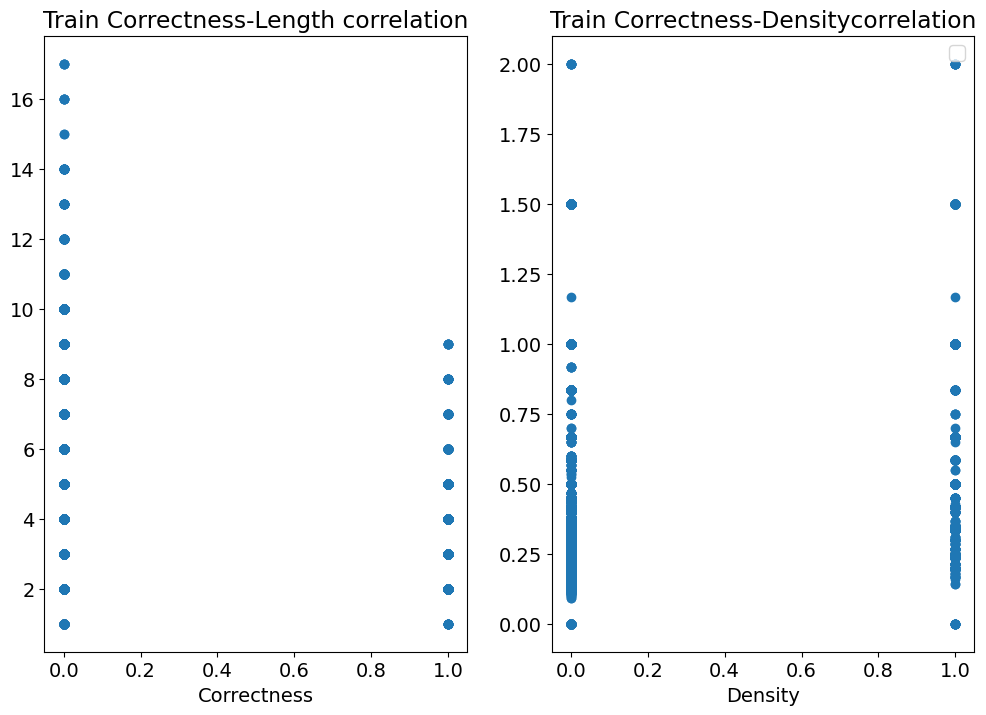

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

ax[0].scatter(train_exploration_df["correct"], train_exploration_df["length"])
ax[0].set_xlabel('Correctness')
ax[0].set_title('Train Correctness-Length correlation')

ax[1].scatter(train_exploration_df["correct"], train_exploration_df["density"])
ax[1].set_xlabel('Density')
ax[1].set_title('Train Correctness-Densitycorrelation')

plt.legend()
plt.show()

In [24]:
test_exploration_df = pd.DataFrame()
test_exploration_df["correct"], test_exploration_df["length"], test_exploration_df["density"] = test_df["correct"], test_df["length"], test_df["density"]
test_exploration_df.head(3)

,correct,length,density
11,False,2,0.5
12,False,3,0.5
13,False,2,0.5


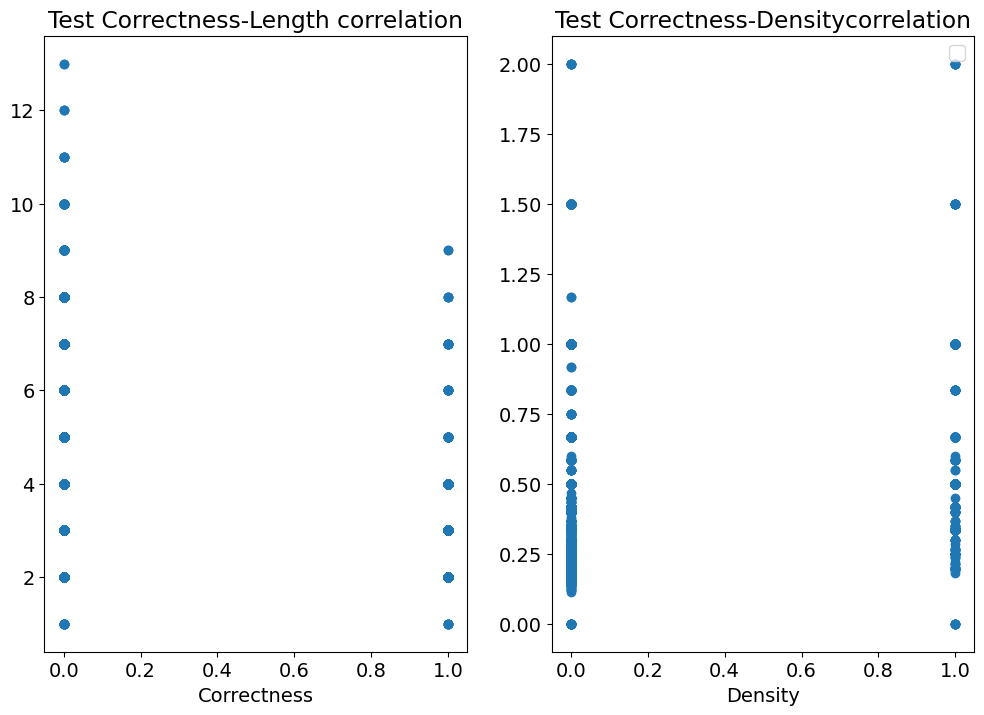

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

ax[0].scatter(test_exploration_df["correct"], test_exploration_df["length"])
ax[0].set_xlabel('Correctness')
ax[0].set_title('Test Correctness-Length correlation')

ax[1].scatter(test_exploration_df["correct"], test_exploration_df["density"])
ax[1].set_xlabel('Density')
ax[1].set_title('Test Correctness-Densitycorrelation')

plt.legend()
plt.show()

In [26]:
experimental_train_df = train_df.drop(train_df[train_df["length"] > 9].index)

In [27]:
train_df.head(2)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label,linearized_graph,length,density
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0,"Iran, country, Iran Iran, replaces, Pahlavi dynasty Pahlavi dynasty, replaced by, Iran [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty",3,0.666667
1,1,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q4173137', 'id': 0, 'label': 'Jewish Encyclopedia of Brockhaus and Efron'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 1, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q47461344', 'id': 2, 'label': 'written work'}, {'type': 'INTERNAL', 'name_': 'Q133492', 'id': 3, 'label': 'letter'}, {'type': 'INTERNAL', 'name_': 'Q1030940', 'id': 4, 'label': 'The Book of Healing'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q5952984', 'id': 5, 'label': 'Ruhollah Khomeini's letter to Mikhail Gorbachev'}], 'links': [{'name_': 'P1343', 'source': 1, 'target': 0, 'label': 'described by source'}, {'name_': 'P17', 'source': 1, 'target': 1, 'label': 'country'}, {'name_': 'P1343', 'source': 3, 'target': 0, 'label': 'described by source'}, {'name_': 'P279', 'source': 3, 'target': 2, 'label': 'subclass of'}, {'name_': 'P495', 'source': 4, 'target': 1, 'label': 'country of origin'}, {'name_': 'P31', 'source': 4, 'target': 2, 'label': 'instance of'}, {'name_': 'P31', 'source': 5, 'target': 2, 'label': 'instance of'}, {'name_': 'P31', 'source': 5, 'target': 3, 'label': 'instance of'}]}",0.0,"Iran, described by source, Jewish Encyclopedia of Brockhaus and Efron Iran, country, Iran letter, described by source, Jewish Encyclopedia of Brockhaus and Efron letter, subclass of, written work The Book of Healing, country of origin, Iran The Book of Healing, instance of, written work [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, written work [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, letter",6,0.266667


# Model Preparation

In [28]:
def train(model, iterator, optimizer, criterion, device,
          train_history=None, valid_history=None,):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        graph_length = batch["graph_length"].to(device)
        graph_density = batch["graph_density"].to(device)

        output = model(inputs=input_ids, attention_mask=attention_mask, graph_length=graph_length, graph_density=graph_density).squeeze(1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


        epoch_loss += loss.item()
        

        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            graph_length = batch["graph_length"].to(device)
            graph_density = batch["graph_density"].to(device)

            true_labels.extend(labels.cpu().numpy())
            labels = labels.to(device)


            output = model(inputs=input_ids, attention_mask=attention_mask, graph_length=graph_length, graph_density=graph_density).squeeze(1)
            pred_probas = output.cpu().numpy()
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(output, labels)

            pred_labels.extend(batch_pred_labels)
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
def train_evaluate(bert_classifier, train_loader, dev_loader, optimizer, scheduler, criterion, n_epochs, checkpoint_fname, device):
    train_history = []
    valid_history = []
    valid_history_f1 = []

    best_valid_loss = float('inf')
    best_f1_score = 0.0

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(bert_classifier, train_loader, optimizer, criterion, device, train_history, valid_history, )
        valid_loss, valid_f1_score = evaluate(bert_classifier, dev_loader, criterion, device)

        #scheduler.step(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_history_f1.append(valid_f1_score)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(valid_history_f1, label='Val f1-score')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Val f1-score')

        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].plot(valid_history, label='general valid history')

        plt.legend()
        plt.show()

        if valid_f1_score > best_f1_score:
            best_f1_score = valid_f1_score
            torch.save(bert_classifier.state_dict(), f'best-val-{checkpoint_fname}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1_score:.3f}')

In [30]:
def predict(model, data_loader, device):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            graph_length = batch["graph_length"].to(device)
            graph_density = batch["graph_density"].to(device)
            batch_true_labels = batch["labels"].cpu().numpy()


            pred_probas = model(inputs=input_ids, attention_mask=attention_mask, graph_length=graph_length, graph_density=graph_density).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            true_labels.extend(batch_true_labels)
            
    return true_labels, pred_labels

In [31]:
torch.Tensor([[1,2,3,4,5]]).reshape(-1, 1).type("torch.FloatTensor").dtype

torch.float32

In [32]:
class BertSimpleClassifier(nn.Module):
    def __init__(self, bert_text_encoder, dropout=0.1):
        super().__init__()

        self.bert_text_encoder = bert_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        bert_hidden_dim = bert_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Tanh(),
            nn.Linear(bert_hidden_dim+2, bert_hidden_dim+2),
            nn.Dropout(p=dropout),
            nn.Tanh(),
            nn.Linear(bert_hidden_dim+2, 1),
        )

#         self.mlp = nn.Sequential(
#             nn.Linear(2, 32),
#             nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
#             nn.Linear(32, 2),
#         )
        
    def forward(self, inputs, attention_mask, graph_length, graph_density):
        last_hidden_states = self.bert_text_encoder(inputs, attention_mask=attention_mask,
                                                    return_dict=True)['last_hidden_state']
        text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
        graph_features = torch.cat((graph_length.type("torch.FloatTensor").reshape(-1, 1), graph_density.type("torch.FloatTensor").reshape(-1, 1)), dim=1).to(device)
#         graph_features = self.mlp(graph_features)
        proba = self.classifier(torch.cat([text_cls_embeddings, graph_features], dim=1))
        return proba


In [33]:
train_df["linearized_graph"].head(1)

0     Iran, country, Iran  Iran, replaces, Pahlavi dynasty  Pahlavi dynasty, replaced by, Iran  [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty 
Name: linearized_graph, dtype: object

In [34]:
test_df["linearized_graph"].head()

11                                                                                                        [SEP] Yogi Berra [SEP], league, Major League Baseball 
12     United States, country, United States  Major League Baseball, country, United States  [SEP] Tony Gwynn, Jr. [SEP], country of citizenship, United States 
13                                                                                                    [SEP] Roy Campanella [SEP], league, Major League Baseball 
14                                                                                                     [SEP] Roger Clemens [SEP], league, Major League Baseball 
15                                                                                                     [SEP] Mickey Mantle [SEP], league, Major League Baseball 
Name: linearized_graph, dtype: object

In [35]:
# model_name="roberta-base"
model_name="sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

#freeze_layer_count = 5
#if freeze_layer_count > 0:
    #for layer in bert_model.encoder.layer[:freeze_layer_count]:
        #for param in layer.parameters():
            #param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

# Trainable params:  10794624


In [36]:
train_df.head(1)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label,linearized_graph,length,density
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0,"Iran, country, Iran Iran, replaces, Pahlavi dynasty Pahlavi dynasty, replaced by, Iran [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty",3,0.666667


In [37]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                      tokenizer_truncation="only_second")
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                    tokenizer_truncation="only_second")
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [38]:
batch_size = 128
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [39]:
N_EPOCHS = 40
DROPOUT = 0.2

In [40]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.AdamW(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                           factor=0.7, patience=1,
                                           threshold=0.005, min_lr=1e-9, verbose=True)

In [41]:
inputs = next(iter(train_loader))
inputs

{'input_ids': tensor([[ 101, 2040, 2003,  ...,    0,    0,    0],
         [ 101, 2054, 2003,  ...,    0,    0,    0],
         [ 101, 2029, 2266,  ...,    0,    0,    0],
         ...,
         [ 101, 2029, 8348,  ...,    0,    0,    0],
         [ 101, 2054, 2003,  ...,    0,    0,    0],
         [ 101, 2040, 2626,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.

In [42]:
train_df.head(1)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label,linearized_graph,length,density
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0,"Iran, country, Iran Iran, replaces, Pahlavi dynasty Pahlavi dynasty, replaced by, Iran [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty",3,0.666667


In [43]:
true_lables, pred_labels = predict(model=bert_linearized_graph_clf, data_loader=test_loader, device=device)

In [44]:
f1_score(true_lables, pred_labels)

0.0

# Training

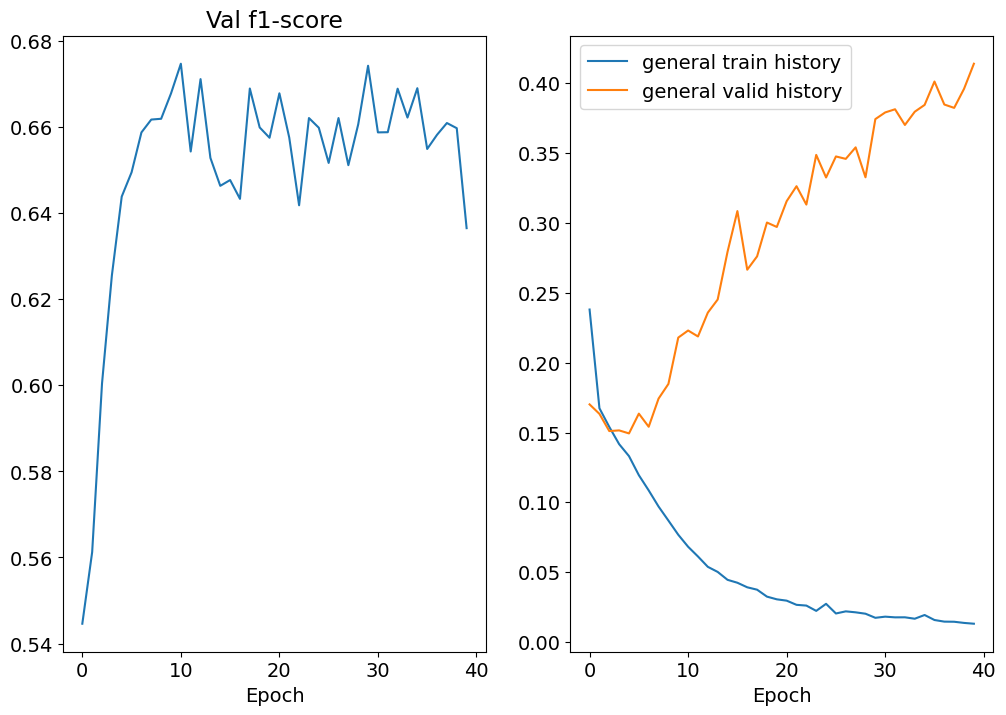

Epoch: 40 | Time: 0m 49s
	Train Loss: 0.013
	 Val. Loss: 0.414 |  Val. F1: 0.637


In [45]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer, scheduler,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

## Evaluation

In [46]:
bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_clf.pt'))

<All keys matched successfully>

In [47]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.724907063197026,0.6310679611650486,0.6747404844290658


In [48]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.6934189406099518,0.5699208443271768,0.6256335988414192


# Test

In [49]:
class TestQuestionAnswerDataset(Dataset):

    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first", graph_length="length", graph_density="density"):
        super(QuestionAnswerDataset).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        self.graph_length = df[graph_length].values
        self.graph_density = df[graph_density].values
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
                "input_ids": self.tokenized_input[idx]["input_ids"][0],
                "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
                "graph_length": self.graph_length[idx],
                "graph_density": self.graph_density[idx],
                }

In [50]:
def predict(model, data_loader, device):
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            graph_length = batch["graph_length"].to(device)
            graph_density = batch["graph_density"].to(device)

            pred_probas = model(inputs=input_ids, attention_mask=attention_mask, graph_length=graph_length, graph_density=graph_density).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            
    return pred_labels

In [51]:
test_data = pd.read_csv("TextGraphs17-shared-task/data/tsv/test.tsv", sep="\t")
test_data.shape

(10961, 7)

In [52]:
test_data["graph"] = test_data["graph"].apply(eval)
test_data["linearized_graph"], test_data["length"], test_data["density"] = zip(*test_data.apply(linearize_graph, axis=1))
test_data.head(2)

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph,linearized_graph,length,density
0,0,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Clash of Kings,Q1213715,Q300370,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q300370', 'id': 1, 'label': 'A Clash of Kings'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}","United States, country, United States [SEP] A Clash of Kings [SEP], country of origin, United States A Time to Kill, country of origin, United States",3,0.5
1,1,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Feast for Crows,Q1213715,Q1764445,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1764445', 'id': 1, 'label': 'A Feast for Crows'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}","United States, country, United States [SEP] A Feast for Crows [SEP], country of origin, United States A Time to Kill, country of origin, United States",3,0.5


In [53]:
max_length = 128

final_test_data = TestQuestionAnswerDataset(test_data, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [54]:
batch_size = 128
num_workers = 0

test_loader = torch.utils.data.DataLoader(
    final_test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [55]:
inputs = next(iter(test_loader))
inputs

{'input_ids': tensor([[ 101, 2044, 4640,  ...,    0,    0,    0],
         [ 101, 2044, 4640,  ...,    0,    0,    0],
         [ 101, 2044, 4640,  ...,    0,    0,    0],
         ...,
         [ 101, 2034, 2931,  ...,    0,    0,    0],
         [ 101, 2034, 2931,  ...,    0,    0,    0],
         [ 101, 2034, 2931,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'graph_length': tensor([ 3,  3,  3,  3,  3,  6,  3,  3,  3,  3,  5,  2,  3,  2,  3,  3,  3,  2,
          3,  2,  2,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  9,  7,  7,
          7,  7,  5,  4,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,  5,  4,  5,  5,
          5,  5,  8,  8,  8,  7,  5,  7,  7,  6,  5,  6,  6,  8,  9,  6,  6, 10,
          6,  6,  7,  4,  6,  8,  5,  5,  5,  5,  5,  7,  8,  5,  7, 

In [56]:
predicted_labels = predict(model=bert_linearized_graph_clf, data_loader=test_loader, device=device)

In [57]:
results = pd.concat([pd.Series(np.arange(len(predicted_labels))), pd.Series(predicted_labels)], axis=1)
results.rename(columns={0: "sample_id", 1: "prediction"}, inplace=True)
results.head(5)

,sample_id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [58]:
results.to_csv("results.csv", index=False, sep="\t")